## Plot results of multi-omics classification experiments

In these experiments, we compare elastic net logistic regression models using multiple data types to models using only a single data type. We're not doing anything particularly fancy here, just concatenating the feature sets (genes or CpG probes) from the individual data types to create a "multi-omics" model.

For now, we're just doing this for gene expression and the two methylation datasets.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import ttest_ind
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# if True, save figures to ./images directory
SAVE_FIGS = True

# if True, use raw feature results, else use compressed features
RAW_FEATS = False

# set results directory
if RAW_FEATS:
    results_dir = Path(
        cfg.results_dirs['multimodal'],
        'pilot_results_all_feats',
        'gene'
    ).resolve()
else:
    results_dir = Path(
        cfg.results_dirs['multimodal'],
        'pilot_results_all_compressed',
        'gene'
    ).resolve()

### Compare raw results (signal and shuffled)

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# drop TET2 for now
results_df = results_df[~(results_df.identifier == 'TET2')].copy()

# make sure that we have data for all data types and for two replicates (random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.identifier.unique())
print(results_df.training_data.unique())
results_df.head()

(1152, 9)
[42  1]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_450k' 'expression.me_27k' 'me_27k.me_450k'
 'expression.me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.97843,0.97294,TP53,expression.me_450k,signal,42,train,0,gene
1,0.93347,0.90974,TP53,expression.me_450k,signal,42,test,0,gene
2,0.90244,0.85693,TP53,expression.me_450k,signal,42,cv,0,gene
3,0.97725,0.97106,TP53,expression.me_450k,signal,42,train,1,gene
4,0.92852,0.89786,TP53,expression.me_450k,signal,42,test,1,gene


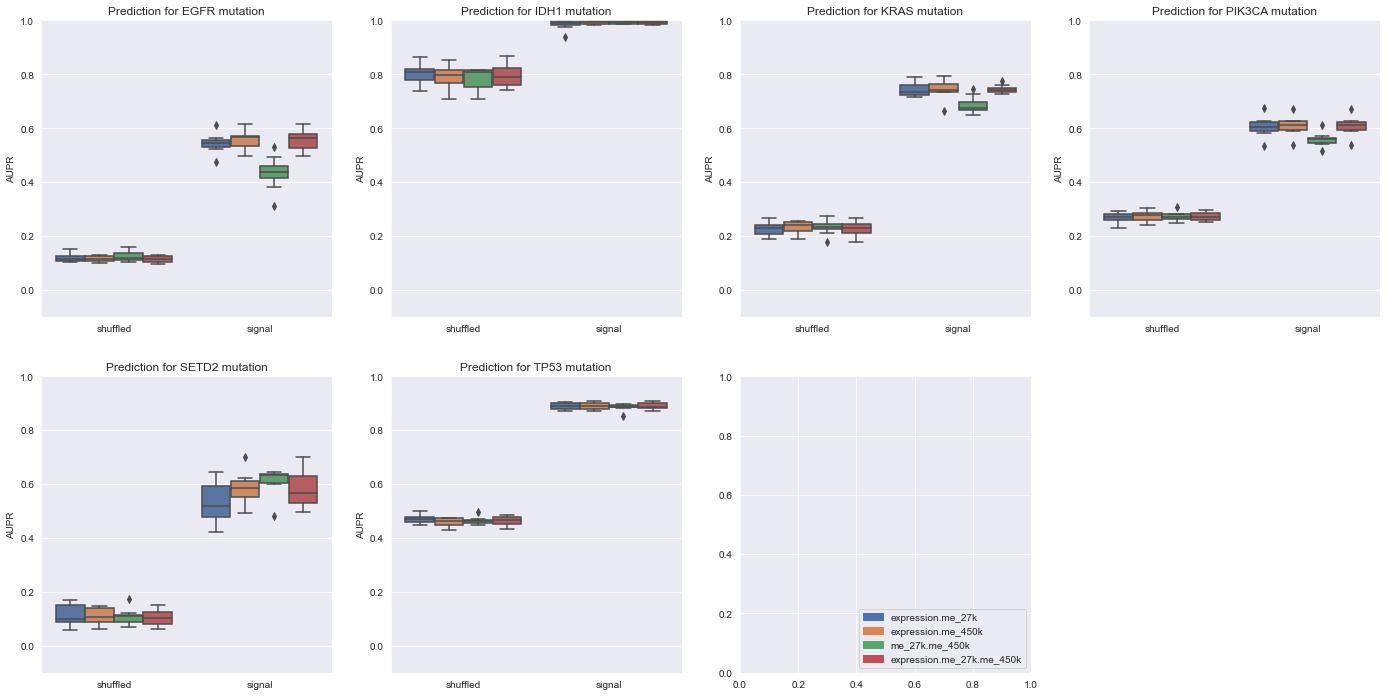

In [4]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (24, 12)})
fig, axarr = plt.subplots(2, 4)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)
max_aupr = results_df.aupr.max()

data_order =['expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

# plot mean performance over all genes in Vogelstein dataset
for ix, gene in enumerate(results_df.identifier.unique()):
    
    ax = axarr[ix // 4, ix % 4]
    
    plot_df = results_df[(results_df.identifier == gene) &
                         (results_df.data_type == 'test')]

    sns.boxplot(data=plot_df, x='signal', y='aupr', hue='training_data',
                hue_order=data_order, ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene))
    ax.set_xlabel('')
    ax.set_ylabel('AUPR')
    ax.set_ylim(-0.1, max_aupr)
    ax.legend_.remove()
    
handles = []
for ix, data in enumerate(data_order):
    handle = mpatches.Patch(color=sns.color_palette()[ix], label=data)
    handles.append(handle)
    
fig.delaxes(axarr[1, 3])
plt.legend(handles=handles, loc='lower right')

### Compare single-omics and multi-omics results

In [5]:
# get results from unimodal prediction (individual data types) to compare with
if not RAW_FEATS:
    unimodal_results_dir = Path(
        cfg.results_dirs['mutation'],
        'methylation_results',
        'gene'
    )

    # load expression and me_27k results
    u_results_df = au.load_compressed_prediction_results(unimodal_results_dir, 'gene')
    u_results_df = u_results_df[(u_results_df.n_dims == 5000)].copy()
    u_results_df.drop(columns='n_dims', inplace=True)

    # make sure data loaded matches our expectations
    print(u_results_df.training_data.unique())
    print(u_results_df.seed.unique())

['expression' 'me_450k' 'me_27k']
[ 1 42]


In [6]:
# first, concatenate the unimodal results and the multimodal results
if not RAW_FEATS:
    all_results_df = pd.concat((results_df, u_results_df))

    print(all_results_df.shape)
    print(all_results_df.training_data.unique())
    all_results_df.head()

(13248, 9)
['expression.me_27k' 'expression.me_27k.me_450k' 'expression.me_450k'
 'me_27k.me_450k' 'expression' 'me_450k' 'me_27k']


In [7]:
# then, for each training data type, get the AUPR difference between signal and shuffled
compare_df = pd.DataFrame()
if RAW_FEATS:
    for training_data in results_df.training_data.unique():
        data_compare_df = au.compare_control_ind(
            results_df[results_df.training_data == training_data],
            identifier='identifier',
            metric='aupr',
            verbose=True
        )
        data_compare_df['training_data'] = training_data
        data_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        compare_df = pd.concat((compare_df, data_compare_df))
else:
    for training_data in all_results_df.training_data.unique():
        data_compare_df = au.compare_control_ind(
            all_results_df[all_results_df.training_data == training_data],
            identifier='identifier',
            metric='aupr',
            verbose=True
        )
        data_compare_df['training_data'] = training_data
        data_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
        compare_df = pd.concat((compare_df, data_compare_df))
    
compare_df.head(10)

,gene,seed,fold,delta_aupr,training_data
0,EGFR,42,0,0.38267,expression.me_27k
1,EGFR,42,1,0.41393,expression.me_27k
2,EGFR,42,2,0.36905,expression.me_27k
3,EGFR,42,3,0.49495,expression.me_27k
4,EGFR,1,0,0.44128,expression.me_27k
5,EGFR,1,1,0.44199,expression.me_27k
6,EGFR,1,2,0.44799,expression.me_27k
7,EGFR,1,3,0.40874,expression.me_27k
8,IDH1,42,0,0.22770,expression.me_27k
9,IDH1,42,1,0.23775,expression.me_27k


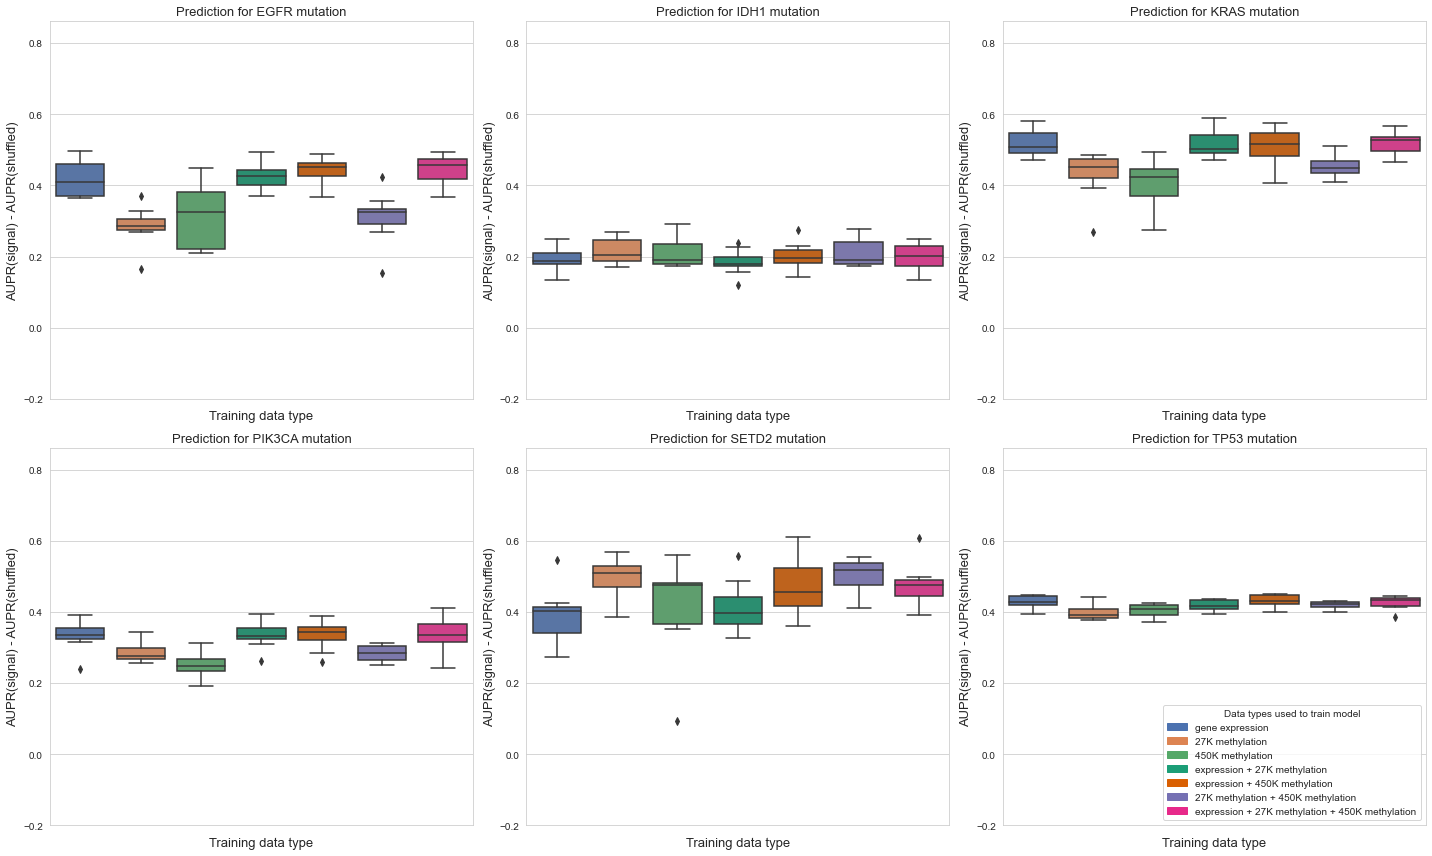

In [8]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (20, 12)})
sns.set_style('whitegrid')

# fig, axarr = plt.subplots(2, 4)
fig, axarr = plt.subplots(2, 3)
compare_df.sort_values(by=['gene', 'training_data'], inplace=True)
compare_map = {v: str(i) for i, v in enumerate(compare_df.training_data.unique())}
min_aupr = compare_df.delta_aupr.min()
max_aupr = compare_df.delta_aupr.max()

data_names = {
    'expression': 'gene expression',
    'me_27k': '27K methylation',
    'me_450k': '450K methylation',
    'expression.me_27k': 'expression + 27K methylation',
    'expression.me_450k': 'expression + 450K methylation',
    'me_27k.me_450k': '27K methylation + 450K methylation',
    'expression.me_27k.me_450k': 'expression + 27K methylation + 450K methylation'
}

# we want to use the same colors as other figures for the individual
# data types, but different colors for the multi-omics models
colors = sns.color_palette()[:3] + sns.color_palette('Dark2')[:4]

# plot mean performance over all genes in pilot experiment
for ix, gene in enumerate(results_df.identifier.unique()):
    
    ax = axarr[ix // 3, ix % 3]
    
    plot_df = compare_df[(compare_df.gene == gene)].copy()
    plot_df.training_data.replace(data_names, inplace=True)

    sns.boxplot(data=plot_df, x='training_data', y='delta_aupr',
                order=list(data_names.values()), palette=colors, ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene), size=13)
    ax.set_xlabel('Training data type', size=13)
    # hide x-axis tick text
    ax.get_xaxis().set_ticklabels([])
    ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
    ax.set_ylim(-0.2, max_aupr)
    
handles = []
for ix, data in enumerate(list(data_names.values())):
    handle = mpatches.Patch(color=colors[ix], label=data)
    handles.append(handle)
    
plt.legend(title='Data types used to train model', handles=handles, loc='lower right')
plt.tight_layout()

if SAVE_FIGS:
    if RAW_FEATS:
        svg_filename = 'multi_omics_boxes_raw_feats.svg'
        png_filename = 'multi_omics_boxes_raw_feats.png'
    else:
        svg_filename = 'multi_omics_boxes.svg'
        png_filename = 'multi_omics_boxes.png'
    images_dir = Path(cfg.images_dirs['multimodal'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / svg_filename, bbox_inches='tight')
    plt.savefig(images_dir / png_filename, dpi=300, bbox_inches='tight')

### Compare best-performing single-omics and multi-omics data types

In [9]:
# for each data type, classify it as single-omics or multi-omics
compare_df['model_type'] = 'Best single-omics'
# multi-omics data types are concatenated using dots
compare_df.loc[compare_df.training_data.str.contains('\.'), 'model_type'] = 'Best multi-omics'
print(compare_df.training_data.unique())
compare_df[compare_df.gene == 'TP53'].head(10)

['expression' 'me_27k' 'me_450k' 'expression.me_27k'
 'expression.me_27k.me_450k' 'expression.me_450k' 'me_27k.me_450k']


,gene,seed,fold,delta_aupr,training_data,model_type
648,TP53,1,0,0.44710,expression,Best single-omics
649,TP53,1,1,0.40218,expression,Best single-omics
650,TP53,1,2,0.42517,expression,Best single-omics
651,TP53,1,3,0.43300,expression,Best single-omics
652,TP53,42,0,0.44681,expression,Best single-omics
653,TP53,42,1,0.39485,expression,Best single-omics
654,TP53,42,2,0.44524,expression,Best single-omics
655,TP53,42,3,0.42392,expression,Best single-omics
40,TP53,42,0,0.43451,expression.me_27k,Best multi-omics
41,TP53,42,1,0.40940,expression.me_27k,Best multi-omics


EGFR diff: -0.0286 (pval: 0.2479)
IDH1 diff: 0.0040 (pval: 0.8424)
KRAS diff: -0.0013 (pval: 0.9424)
PIK3CA diff: -0.0054 (pval: 0.8047)
SETD2 diff: -0.0070 (pval: 0.8165)
TP53 diff: -0.0037 (pval: 0.7065)


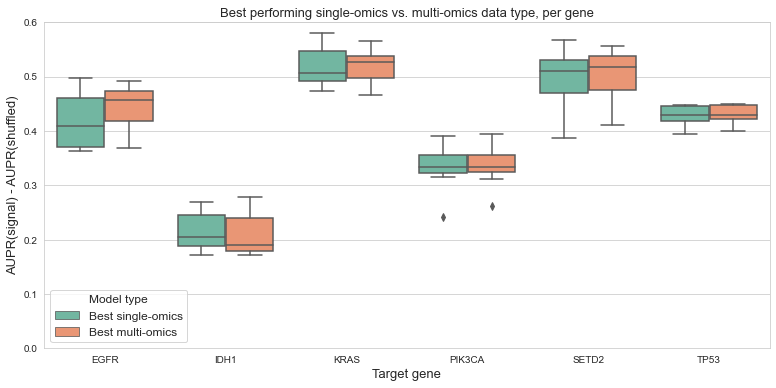

In [10]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

plot_df = pd.DataFrame()

# plot mean performance over all genes in pilot experiment
for ix, gene in enumerate(results_df.identifier.unique()):
    
    plot_gene_df = compare_df[(compare_df.gene == gene)].reset_index(drop=True)
    
    # get the best-performing data types from the single-omics and multi-omics models
    max_single_data_type = (
        plot_gene_df[plot_gene_df.model_type.str.contains('single-omics')]
          .groupby('training_data')
          .agg('mean')
          .delta_aupr.idxmax()
    )
    max_multi_data_type = (
        plot_gene_df[plot_gene_df.model_type.str.contains('multi-omics')]
          .groupby('training_data')
          .agg('mean')
          .delta_aupr.idxmax()
    )
    
    # get samples with that data type
    max_single_df = plot_gene_df[plot_gene_df.training_data == max_single_data_type]
    max_multi_df = plot_gene_df[plot_gene_df.training_data == max_multi_data_type]
    
    # calculate difference between means and t-test p-val for that data type
    mean_diff = max_single_df.delta_aupr.mean() - max_multi_df.delta_aupr.mean()
    _, p_val = ttest_ind(max_single_df.delta_aupr.values,
                         max_multi_df.delta_aupr.values)
    print('{} diff: {:.4f} (pval: {:.4f})'.format(gene, mean_diff, p_val))
    
    plot_df = pd.concat((plot_df, max_single_df, max_multi_df))

colors = sns.color_palette('Set2')
sns.boxplot(data=plot_df, x='gene', y='delta_aupr', hue='model_type', palette=colors)
plt.title('Best performing single-omics vs. multi-omics data type, per gene', size=13)
plt.xlabel('Target gene', size=13)
plt.ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
if RAW_FEATS:
    plt.ylim(0.0, 0.7)
else:
    plt.ylim(0.0, 0.6)
plt.legend(title='Model type', loc='lower left', fontsize=12, title_fontsize=12)

if SAVE_FIGS:
    if RAW_FEATS:
        svg_filename = 'multi_omics_best_model_raw_feats.svg'
        png_filename = 'multi_omics_best_model_raw_feats.png'
    else:
        svg_filename = 'multi_omics_best_model.svg'
        png_filename = 'multi_omics_best_model.png'
    images_dir = Path(cfg.images_dirs['multimodal'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / svg_filename, bbox_inches='tight')
    plt.savefig(images_dir / png_filename, dpi=300, bbox_inches='tight')